In [2]:
from Bio.PDB import *
import numpy as np
import csv
import matplotlib.pyplot as plt
from operator import itemgetter
import networkx as nx

In [3]:
def calc_residue_dist(residue_one, residue_two, method = "heavy"):
    """Returns the minimum distance between two residues
    default method is between heavy atoms
    method can be calpha, allatom"""
    dist_ij = []
    
    if method == 'allatom':
        for i in residue_one:
            for j in residue_two:
                r_ij = np.linalg.norm(i.coord - j.coord)
                dist_ij.append(r_ij)
    elif method == 'calpha':
        for i in residue_one:
            for j in residue_two:
                if i.id in ['CA','OW'] and j.id in ['CA', 'OW']:
                    r_ij = np.linalg.norm(i.coord - j.coord)
                    dist_ij.append(r_ij)
    elif method == 'oxygen-calcium':
        for i in residue_one:
            for j in residue_two:
                if i.mass > 15 and j.mass > 15:
                    r_ij = np.linalg.norm(i.coord - j.coord)
                    dist_ij.append(r_ij)
    else:
        for i in residue_one:
            for j in residue_two:
                if i.mass > 12 and j.mass > 12:
                    r_ij = np.linalg.norm(i.coord - j.coord)
                    dist_ij.append(r_ij)
    
    # If there is no oxgyen (cap)
    # then return a large distance
    if not dist_ij:
        return 99
    else:
        return min(dist_ij)

def calc_dist_matrix(chain_one, chain_two, method='oxygen-calcium') :
    """Returns a matrix of minimum distances between two chains"""
    n_rows = len([res for res in chain_one.get_residues()])
    n_cols = len([res for res in chain_two.get_residues()])

    answer = np.zeros((n_rows, n_cols), np.float)
    row = 0
    for residue_one in chain_one.get_residues():
        col = 0
        for residue_two in chain_two.get_residues():
            answer[row, col] = calc_residue_dist(residue_one, residue_two, method)
            col = col + 1
        row = row + 1
    return answer

In [4]:
def loop_dist_matrix(dist_matrix):
    '''returns a symmetrical array'''
    mloop = dist_matrix[1:13,1:13]
    mloop_ca = dist_matrix[1:13,14:15]

    # Compose the full distance matrix
    # The matrix should be 14 x 14 

    mtot = np.zeros((14, 14), np.float)
    mtot[:12,:12] = mloop
    mtot[:12,12:13] = mloop_ca
    mtot[12:13,:12] = np.transpose(mloop_ca)


    # If there is >= 1 water
    # find the water nearest to the calcium ion
    if len(dist_matrix) > 15:
        mwater_ca = dist_matrix[15:,14:15]
        water_id = np.argmin(mwater_ca)+15
        mloop_water = dist_matrix[1:13,water_id]
        mca_water = dist_matrix[14:15,water_id]
        
        mtot[:12,13] = mloop_water
        mtot[13,:12] = np.transpose(mloop_water)

        mtot[12:13,13] = mca_water
        mtot[13,12:13] = np.transpose(mca_water)

    return mtot

In [5]:
def contact(filename, mtot, cutoff = 6):
    '''default cut off is 6 angstroms if not provided.'''
    msize = len(mtot)                
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(('Source','Target','Type','Weight'))
        for i in range(msize):
            for j in range(i+1,msize):
                if mtot[i,j] < cutoff:
                    #print(i,j, 1/mtot[i,j], sep=',')
                    writer.writerow((i,j,'Undirected',1/mtot[i,j]))

In [6]:
def network(inputcsv, outputcsv):
    edgelist = dict()
    with open(inputcsv, 'r') as fh:
        ereader = csv.reader(fh) # Read the csv

        # Retrieve the data (using Python list comprhension and list slicing to remove the header row)
        for j in [n for n in ereader][1:]:
            if j[0] not in edgelist:
                edgelist[j[0]]={j[1]:{"weight":j[3]}}
            else:
                edgelist[j[0]][j[1]]={"weight":j[3]}
    
    G = nx.Graph(edgelist)
    # In case some graphs are not complete
    G.add_nodes_from([str(i) for i in range(14)])
    #print(nx.degree(G))
    deg_centrality = nx.degree_centrality(G)
    bet_centrality = nx.betweenness_centrality(G, normalized = True, endpoints = False)
    close_centrality = nx.closeness_centrality(G)
    cluster_coeff = nx.clustering(G)
    #sorted(cluster_coeff.items(), key=lambda x: int(x[0]), reverse=False) 
    
    with open(outputcsv, 'w') as fout:
        csvwriter = csv.writer(fout)
        csvwriter.writerow(('node','degree_cent','bet_cent','clust_coeff','close_cent'))
        for i in range(G.number_of_nodes()):
            i = str(i)
            csvwriter.writerow((i, deg_centrality[i], bet_centrality[i],cluster_coeff[i],close_centrality[i]))
    return (deg_centrality, bet_centrality, close_centrality, cluster_coeff)

In [9]:
# Main code
import glob
import sys

allpdb = glob.glob("pdb/*.pdb")
deg_centrality = []
bet_centrality = []
close_centrality = []
cluster_coeff = []

counter = 0
for struct in allpdb:
    pdb_code = struct.split('/')[1].split('.pdb')[0]
    structure = PDBParser().get_structure(pdb_code, struct)
    dist_matrix = calc_dist_matrix(structure,structure, method='heavy')

    dist = loop_dist_matrix(dist_matrix)
    edgefile = 'edgelist.'+pdb_code+'.csv'
    netparmfile = 'net.'+pdb_code+'.csv'
    contact(edgefile, dist)
    (dc, bc, cce, cco) = network(edgefile,netparmfile)
    deg_centrality.append(dc)
    bet_centrality.append(bc)
    close_centrality.append(cce)
    cluster_coeff.append(cco)
    
    counter = counter + 1
    if counter % 100 == 0:
        print(counter, "structures processed ...", end = '\r')
        sys.stdout.flush()

In [10]:
from scipy.stats.kde import gaussian_kde
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

def ridgeline(data, overlap=0, y_scale = 50, fill=True, labels=None, n_points=150):
    """
    Creates a standard ridgeline plot.

    data, list of lists.
    overlap, overlap between distributions. 1 max overlap, 0 no overlap.
    fill, matplotlib color to fill the distributions.
    n_points, number of points to evaluate each distribution function.
    labels, values to place on the y axis to describe the distributions.
    """
    if overlap > 1 or overlap < 0:
        raise ValueError('overlap must be in [0 1]')
    xx = np.linspace(np.min(np.concatenate(data)),
                     np.max(np.concatenate(data)), n_points)
    curves = []
    ys = []
    for i, d in enumerate(data):
        pdf = gaussian_kde(d)
        y = i*(1.0-overlap)*y_scale
        ys.append(y)
        curve = pdf(xx)
        if fill:
            plt.fill_between(xx, np.ones(n_points)*y, 
                             curve+y, zorder=len(data)-i+1, color=fill)
        plt.plot(xx, curve+y, c='k', zorder=len(data)-i+1)
    if labels:
        plt.yticks(ys, labels)

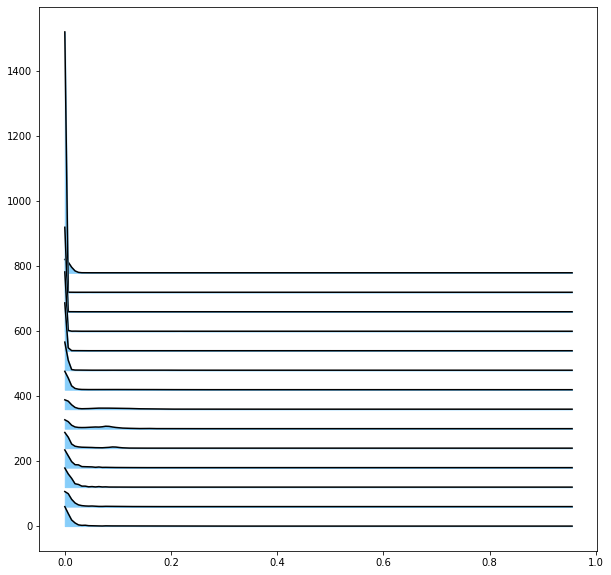

In [112]:
# Plot betweenness centrality
a = list()
for i in bet_centrality:
    if len(i) < 14:
        continue
    a.append(np.array(list(i.values())))

b = np.array(a)

plt.figure(figsize=(10,10))
ridgeline(b.transpose(), y_scale = 100, overlap = 0.4, fill='lightskyblue')
#b.transpose().shape
#plt.savefig('dist_betweenness.eps', format='eps')

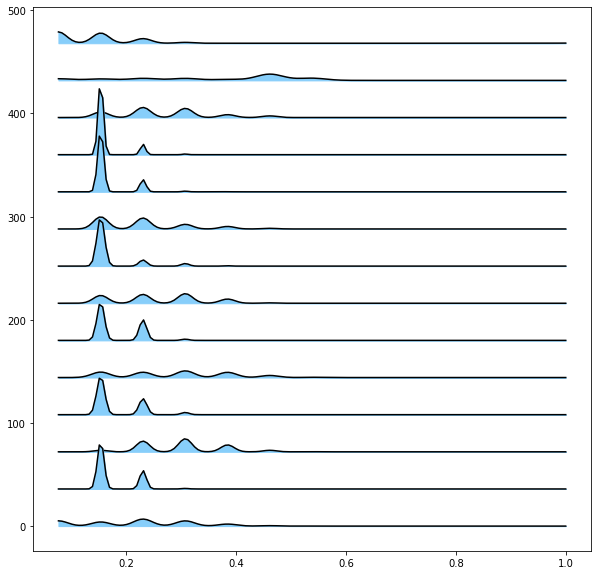

In [51]:
# Plot degree centrality
a = list()
for i in deg_centrality:
    if len(i) < 14:
        continue
    a.append(np.array(list(i.values())))

b = np.array(a)
plt.figure(figsize=(10,10))
ridgeline(b.transpose(), y_scale = 60, overlap = 0.4, fill='lightskyblue')
plt.savefig('degree.eps', format='eps')

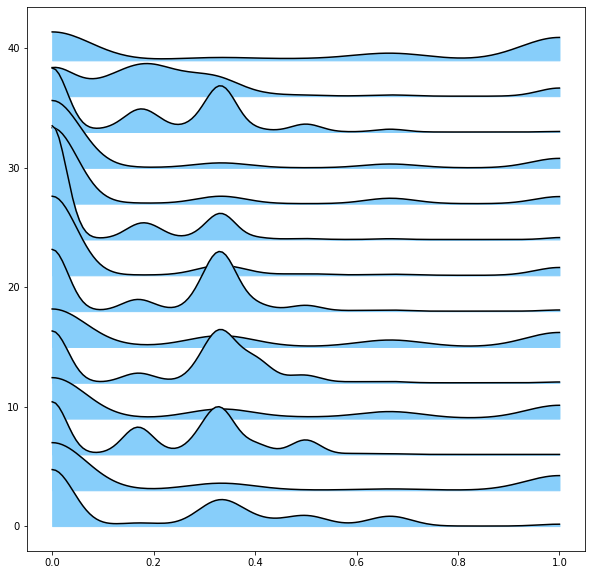

In [53]:
# Plot clustering coefficient
a = list()
for i in cluster_coeff:
    if len(i) < 14:
        continue
    a.append(np.array(list(i.values())))

b = np.array(a)
plt.figure(figsize=(10,10))
ridgeline(b.transpose(), y_scale = 5, overlap = 0.4, fill='lightskyblue')
plt.savefig('clustering_coeff.eps', format='eps')